# Exam 2022

In [2]:
import os
import cv2
import scipy
import skimage
import slgbuilder
import numpy as np
import maxflow.fastmin
from skimage import io
import matplotlib.pyplot as plt

## Question 1

Gaussian derivative 2D Gaussian kernels can be used for feature detection in scalespace. Below we show some kernels related to the 2D first order Gaussian derivative
with σ = 1. The kernel values are shown in the spatial range ±2σ and the image next
to the kernel values is shown in the spatial range ±5σ.
Which kernel best represents the 2D first order Gaussian derivative used for scale-space
computation?

In [6]:
def gauss_kernels(sigma, size=4):
    s = np.ceil(np.max([sigma*size, size]))
    x = np.arange(-s,s+1)
    x = x.reshape(x.shape + (1,))
    g = np.exp(-x**2/(2*sigma*sigma))
    g /= np.sum(g)
    dg = -x/(sigma*sigma)*g
    ddg = -1/(sigma*sigma)*g -x/(sigma*sigma)*dg
    return g, dg, ddg


g, dg, ddg = gauss_kernels(sigma=1, size=2)
g2d = np.outer(g,dg)
g2d

array([[ 0.00593803,  0.01330621, -0.        , -0.01330621, -0.00593803],
       [ 0.02661242,  0.0596343 , -0.        , -0.0596343 , -0.02661242],
       [ 0.04387646,  0.09832033, -0.        , -0.09832033, -0.04387646],
       [ 0.02661242,  0.0596343 , -0.        , -0.0596343 , -0.02661242],
       [ 0.00593803,  0.01330621, -0.        , -0.01330621, -0.00593803]])

In [8]:
g, dg, ddg = gauss_kernels(sigma=2, size=1)
g2d = np.outer(g,dg)
g2d

array([[ 0.01162342,  0.00845599, -0.        , -0.00845599, -0.01162342],
       [ 0.01691198,  0.01230339, -0.        , -0.01230339, -0.01691198],
       [ 0.01916378,  0.01394157, -0.        , -0.01394157, -0.01916378],
       [ 0.01691198,  0.01230339, -0.        , -0.01230339, -0.01691198],
       [ 0.01162342,  0.00845599, -0.        , -0.00845599, -0.01162342]])

Answer: b

## Question 2 

Scale-space blob detection The image blobs.png contains a bright and a dark
blob. The task is to detect the bright blob using Laplacian scale-space. We have precomputed a linear Laplacian scale-space and the result is available in the data folder
as the 3D image blobs_Laplace.tif with [scale, row, column] in the
three dimensions. You can load the blobs_Laplace.tif file using the function
skimage.io.imread in Python or tiffreadVolume in Matlab. The Laplacian
scale-space is computed using a kernel with scale t = 16 (σ = 4), and the first layer of
the image is at scale t = 16, the second layer at t = 32, etc.
At which scale and position (coordinates are 0-indexed) is the bright blob detected?

In [274]:
def getGaussDerivative(t):
    '''
    Computes kernels of Gaussian and its derivatives.
    Parameters
    ----------
    t : float
        Vairance - t.

    Returns
    -------
    g : numpy array
        Gaussian.
    dg : numpy array
        First order derivative of Gaussian.
    ddg : numpy array
        Second order derivative of Gaussian
    dddg : numpy array
        Third order derivative of Gaussian.

    '''

    kSize = 5
    s = np.sqrt(t)
    x = np.arange(int(-np.ceil(s*kSize)), int(np.ceil(s*kSize))+1)
    x = np.reshape(x,(-1,1))
    g = np.exp(-x**2/(2*t))
    g = g/np.sum(g)
    dg = -x/t*g
    ddg = -g/t - x/t*dg
    dddg = -2*dg/t - x/t*ddg
    return g, dg, ddg, dddg

im = skimage.io.imread('EXAM_MATERIAL/blobs.png').astype(float)

t = 16 
g, dg, ddg, dddg = getGaussDerivative(t)

r,c = im.shape
n = 400
L_blob_vol = np.zeros((r,c,n))
tStep = np.zeros(n)

Lg = im
for i in range(0,n):
    tStep[i] = t*i
    L_blob_vol[:,:,i] = tStep[i]*(cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, ddg.T) + 
        cv2.filter2D(cv2.filter2D(Lg, -1, ddg), -1, g.T))
    Lg = cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, g.T)


#%% find maxima in scale-space
thres = 40.0
coord_pos = skimage.feature.peak_local_max(L_blob_vol, threshold_abs = thres)
coord_neg = skimage.feature.peak_local_max(-L_blob_vol, threshold_abs = thres)
coord = np.r_[coord_pos,coord_neg]

# Show circles
theta = np.arange(0, 2*np.pi, step=np.pi/100)
theta = np.append(theta, 0)
circ = np.array((np.cos(theta),np.sin(theta)))
n = coord.shape[0]
m = circ.shape[1]


#%%
scale = tStep[coord[:,2]]

In [275]:
scale

array([160., 208.])

In [280]:
tStep[coord_neg[:,2]]

array([208.])

In [279]:
coord_neg

array([[ 80, 122,  13]])

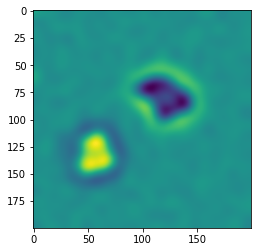

In [273]:
I = io.imread('EXAM_MATERIAL/blobs_Laplace.tif')
plt.imshow(I[2])

In [283]:
208/16

13.0

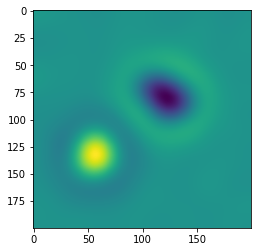

In [285]:
plt.imshow(I[12])

Answer: (e) Scale: 192, position (row, col): (80, 122)

## Question 3

In [10]:
C16 = 4+350+1+45+147+36

C16_l1 = 4+45
C16_l2 = 350+147
C16_l3 = 1+36

p16_l1 = C16_l1/C16
p16_l2 = C16_l2/C16
p16_l3 = C16_l3/C16

print(f'l1: {p16_l1}, l2: {p16_l2}, l3: {p16_l3}')
print(f'total: {p16_l1 + p16_l2 + p16_l3}')

l1: 0.08404802744425385, l2: 0.8524871355060034, l3: 0.0634648370497427
total: 1.0


Answer: (c) [0.08, 0.85, 0.06]

## Question 4

Segmentation with image patches We wish to segment an image using image patches
as described in the lecture notes, Section 3.1.1. We have a gray-scale image of size
512 × 512, we use patches of size 7 × 7, and we segment to four labels.
What is the size of the resulting probability image?

Answer: (c) 506 × 506 × 4

## Question 5

Matching SIFT features SIFT features have been computed for the two images
kidney_1.png and kidney_2.png shown below. The descriptors are stored in
the files SIFT_1_descriptors.txt and SIFT_2_descriptors.txt, available in the data folder. The spatial positions where the SIFT features are detected
are in the files SIFT_1_coordinates.txt and SIFT_2_coordinates.txt,
which are also available. In all file names the numbers 1 and 2 refer to the image
number. We consider the first feature from Image 1, i.e. the first row of the file
SIFT_1_descriptors.txt.

In [244]:
coords1 = np.loadtxt('EXAM_MATERIAL/SIFT_1_coordinates.txt')
des1 = np.loadtxt('EXAM_MATERIAL/SIFT_1_descriptors.txt')
coords2 = np.loadtxt('EXAM_MATERIAL/SIFT_2_coordinates.txt')
des2 = np.loadtxt('EXAM_MATERIAL/SIFT_2_descriptors.txt')

In [257]:
p1 = coords1[0]
p1

array([ 92.002, 290.622])

In [260]:
closest_match = np.argmin(np.linalg.norm(coords2-p1), axis=0)
closest_match

0

In [269]:
np.sqrt(np.sum(des1[0,:]-des2[0,:])**2)

30.0

## Question 6

Feature-based image registration By matching the SIFT features, as shown in the
figure, we have obtained correspondence between feature points. Based on this we
want to register the images, as described in the lecture note. We have computed the
following covariance matrix
C =
[
191955 −937044
552183 379358 ]
,
that we use for computing the transformation

In [18]:
C = np.array([
    [191955, -937044],
    [552183, 379358]
])
C

array([[ 191955, -937044],
       [ 552183,  379358]])

In [19]:
U, S, VT = np.linalg.svd(C)

In [20]:
R_hat = U@VT

In [21]:
D = np.array([
    [1, 0],
    [0, np.linalg.det(R_hat)]
])
R = R_hat @ D

In [22]:
np.arccos(R[0,0])/np.pi*180

69.01165964850452

Answer: (f) 69.0

## Question 7

Gaussian convolution Which statement is correct?

Answer: (b) To ensure high precision when iteratively applying Gaussian kernels for a Gaussian scale-space, the kernels must have a large spatial support, e.g. ±4σ to ±5σ.

But not quite sure

## Question 8

MRF prior energy Consider an MRF segmentation with three labels: 1, 2, and 3.
As in the lecture note, we use first-order neighborhood. We define 2-clique potentials
as
V2(fi
, fi
0 ) = 10|fi − fi
0 |
which is different than what we used in the lecture note. Consider the configuration
configuration.txt given in the illustration.

In [23]:
I = np.loadtxt('EXAM_MATERIAL/configuration.txt')
I

array([[1., 1., 1., 1., 2., 2., 2.],
       [1., 2., 2., 1., 2., 3., 2.],
       [2., 3., 2., 1., 2., 3., 2.],
       [2., 2., 2., 1., 1., 3., 2.],
       [1., 2., 1., 1., 1., 1., 1.]])

In [27]:
V2 = (10*np.abs(I[1:,:]-I[:-1,:])).sum() + (10*np.abs(I[:,1:] - I[:,:-1])).sum()
V2

300.0

Answer: (j) 300

## Question 9

Likelihood energy Consider segmentation of the image I, available in the data folder
as blended.png. Image values should be normalized to be in the range [0, 1] by
dividing the pixel values by 255 after loading.

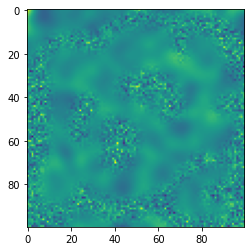

In [30]:
I = io.imread('EXAM_MATERIAL/blended.png').astype(float)
I = I/255
plt.imshow(I)

In [33]:
I.shape

(100, 100)

In [31]:
def window_std(I):
    window = np.ones(shape=(5, 5))/25
    K_I2 = scipy.ndimage.convolve(I**2, window, mode='reflect')
    KI_2 = scipy.ndimage.convolve(I, window, mode='reflect')**2
    return np.sqrt(K_I2 - KI_2)

In [32]:
S = window_std(I)
S.shape

(100, 100)

In [34]:
sigma_textured = 0.05
sigma_smooth = 0.01

V1 = np.stack([(sigma_textured - S)**2, (sigma_smooth - S)**2])
V1.shape

(2, 100, 100)

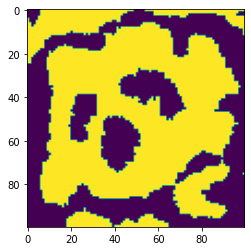

In [39]:
S0 = np.argmin(V1, axis=0)
plt.imshow(S0)

In [40]:
likelihood = np.sum(V1)
likelihood

14.953605251125804

Answer: (i) 14.95

## Question 10

In [41]:
m_in = 0 
m_out = 1

f_ext = (m_in - m_out) * (2*0 - m_in - m_out)
f_ext

1

Answer: (e) 1

## Question 11

Curve smoothing Consider a noisy curve in the illustration, available in the data
folder as hand_noisy.txt.

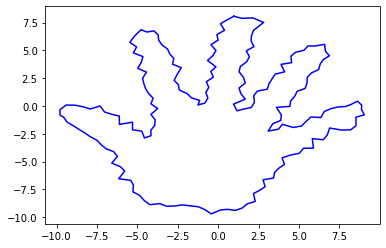

In [45]:
I = np.loadtxt('EXAM_MATERIAL/hand_noisy.txt')
N = I.shape[0]
closed_ind = np.r_[np.arange(N),0] # for easy plotting a closed snake

fig, ax = plt.subplots()
ax.plot(I[closed_ind,0],I[closed_ind,1],'b')

In [43]:
def regularization_matrix(N, alpha, beta):
    """An NxN matrix for imposing elasticity and rigidity to snakes.
    Arguments: alpha is weigth for second derivative (elasticity),
    beta is weigth for (-)fourth derivative (rigidity)."""
    column = np.zeros(N)
    column[[-2,-1,0,1,2]] = alpha*np.array([0,1,-2,1,0]) + beta*np.array([-1,4,-6,4,-1])
    A = scipy.linalg.toeplitz(column)
    return(scipy.linalg.inv(np.eye(N)-A))


alpha = 100
beta = 0

smoothed1_I = np.matmul(regularization_matrix(N,alpha,beta),I)

alpha = 0
beta = 100
smoothed2_I = np.matmul(regularization_matrix(N,alpha,beta),I)

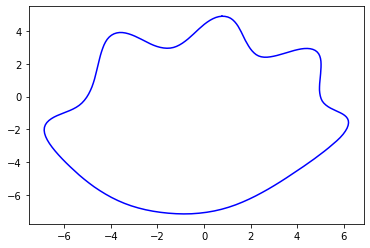

In [47]:
N = smoothed1_I.shape[0]
closed_ind = np.r_[np.arange(N),0] # for easy plotting a closed snake

fig, ax = plt.subplots()
ax.plot(smoothed1_I[closed_ind,0],smoothed1_I[closed_ind,1],'b')

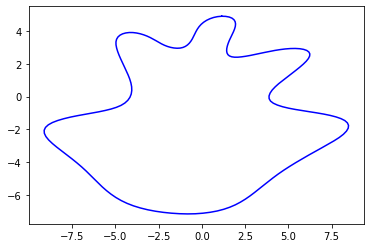

In [48]:
N = smoothed2_I.shape[0]
closed_ind = np.r_[np.arange(N),0] # for easy plotting a closed snake

fig, ax = plt.subplots()
ax.plot(smoothed2_I[closed_ind,0],smoothed1_I[closed_ind,1],'b')

In [49]:
def curve_length(X):
    d = X-np.roll(X, shift=1, axis=0)
    d = (d**2).sum(axis=1)
    d = (np.sqrt(d)).sum()
    return(d)

In [50]:
L_smooth1 = curve_length(smoothed1_I)
L_smooth1

41.0716952120271

In [51]:
L_smooth2 = curve_length(smoothed2_I)
L_smooth2

79.51555179114004

In [53]:
L_smooth1-L_smooth2

-38.44385657911294

Answer: (a) −38.4

## Question 12

What is the cost associated with a solution yielding surfaces s1 and s2?

In [57]:
I = np.loadtxt('EXAM_MATERIAL/layers.txt')
I

array([[62., 58., 58., 67., 62., 68., 62., 58., 66., 58.],
       [63., 25., 56., 66., 21., 21., 32., 21., 39., 53.],
       [24., 64., 39., 32., 54., 52., 50., 52., 66., 30.],
       [53., 57., 68., 50., 67., 59., 67., 55., 69., 68.],
       [53., 54., 54., 58., 69., 63., 87., 67., 68., 67.],
       [64., 93., 65., 82., 92., 86., 58., 88., 85., 82.],
       [80., 52., 91., 51., 67., 64., 59., 66., 65., 59.],
       [61., 67., 69., 60., 56., 61., 69., 52., 62., 60.]])

In [60]:
S1 = [2, 1, 2, 2, 1, 1, 1, 1, 1, 2]
S2 = [6, 5, 6, 5, 5, 5, 4, 5, 5, 5]

cost = (I[S1, np.arange(len(S1))]).sum()
cost += (I[S2, np.arange(len(S1))]).sum()

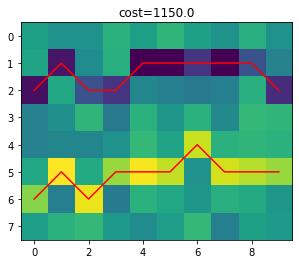

In [61]:
fig, ax = plt.subplots()
ax.imshow(I)
ax.plot(S1, 'r')
ax.plot(S2, 'r')
ax.set_title(f'cost={cost}')
plt.show()

Answer: (e) 1150

## Question 13

In [62]:
I = np.loadtxt('EXAM_MATERIAL/cost.txt')
I

array([[40., 43., 14., 30., 90., 12., 80., 70., 83., 95.],
       [43., 25., 56., 66., 21., 21., 32., 21., 39., 53.],
       [26., 13., 68., 50., 67., 59., 67., 55., 69., 68.],
       [78., 11., 65., 52., 32., 46., 58., 38., 45., 22.],
       [21., 24., 91., 51., 67., 64., 59., 66., 65., 59.],
       [90., 13., 69., 60., 56., 61., 69., 52., 62., 60.]])

In [65]:
S0_row = np.argmin(I.sum(axis=1))
S0_row

1

In [68]:
S0 = [1]*I.shape[1]
S0

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

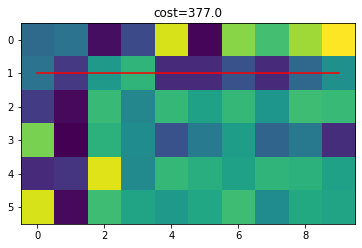

In [87]:
delta = 0
layer = slgbuilder.GraphObject(I)
helper = slgbuilder.MaxflowBuilder()
helper.add_object(layer)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=delta, wrap=False)
helper.solve()
segmentation0 = helper.what_segments(layer)
segmentation_line0 = segmentation0.shape[0] - np.argmax(segmentation0[::-1,:], axis=0) - 1
c = (I[segmentation_line0, np.arange(segmentation0.shape[1])]).sum()

fig, ax = plt.subplots()
ax.imshow(I)
ax.plot(segmentation_line0, 'r')
ax.set_title(f'cost={c}')
plt.show()

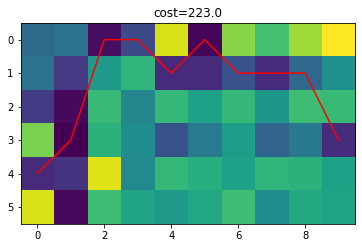

In [88]:
delta = 5
layer = slgbuilder.GraphObject(I)
helper = slgbuilder.MaxflowBuilder()
helper.add_object(layer)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=delta, wrap=False)
helper.solve()
segmentation = helper.what_segments(layer)
segmentation_line = segmentation.shape[0] - np.argmax(segmentation[::-1,:], axis=0) - 1
c = (I[segmentation_line, np.arange(segmentation.shape[1])]).sum()

fig, ax = plt.subplots()
ax.imshow(I)
ax.plot(segmentation_line, 'r')
ax.set_title(f'cost={c}')
plt.show()

In [99]:
np.mean(np.abs(segmentation_line0-segmentation_line))

1.0

Answer: (d) 1

## Question 14

In [185]:
data = np.loadtxt('EXAM_MATERIAL/in_t_out.txt')
P = data[:, :3]
T = data[:,3]
Y_hat = data[:,4:]

In [186]:
P

array([[ 0.2,  0.5,  0.1],
       [-0.8, -0.1,  0.1],
       [ 0.5,  0.4, -0.3],
       [-0.5,  0.7,  0.1],
       [ 0.3, -0.3,  0.2],
       [ 0.2,  0.1, -0.6]])

In [187]:
# T = np.vstack(T)
T

array([0., 1., 0., 1., 0., 0.])

In [203]:
target = np.array([
    [1, 0],
    [0, 1],
    [1, 0],
    [0, 1],
    [1, 0],
    [1, 0]
])
target

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0]])

In [204]:
Y_hat

array([[-0.097,  0.537],
       [ 0.185,  0.261],
       [-0.021,  0.532],
       [ 0.215,  0.244],
       [ 0.191,  0.132],
       [ 0.221,  0.549]])

In [205]:
def softmax(y_hat):
    return np.exp(y_hat)/np.sum(np.exp(y_hat))

Y_pred = softmax(Y_hat)
Y_pred

array([[0.05799807, 0.10933424],
       [0.0768926 , 0.08296424],
       [0.06257774, 0.10878894],
       [0.07923433, 0.08156577],
       [0.07735534, 0.07292341],
       [0.07971116, 0.11065416]])

In [226]:
import math
-(math.log(Y_pred[0,0]) + math.log(Y_pred[1,1]) + math.log(Y_pred[2,0]) + math.log(Y_pred[3,1]) + math.log(Y_pred[4, 0]) + math.log(Y_pred[5,0]))

15.703073735755506

In [222]:
-np.sum(target*np.log(Y_pred))

15.703073735755506

In [223]:
scipy.stats.entropy(target, Y_pred)

array([0.45530868, 1.23594485])

## Question 15

In [227]:
W1 = np.loadtxt('EXAM_MATERIAL/W1.txt')
W1

array([[-0.678,  1.441,  2.133,  1.105, -0.621],
       [ 0.4  ,  3.415, -2.082, -0.933, -0.45 ],
       [-0.064, -1.101, -1.553,  4.059,  0.007]])

In [228]:
W2 = np.loadtxt('EXAM_MATERIAL/W2.txt')
W2

array([[ 1.231,  0.331,  0.914,  0.714,  0.355],
       [ 0.077, -0.211, -0.336, -0.298,  0.411],
       [ 2.251,  1.095, -1.58 ,  0.477, -2.633],
       [-1.175, -0.791,  1.862,  2.101,  1.93 ],
       [-0.036,  2.624, -0.261, -4.076,  0.952],
       [ 0.14 , -0.3  , -0.274,  0.269,  0.215]])

In [229]:
W3 = np.loadtxt('EXAM_MATERIAL/W3.txt')
W3

array([[-0.181,  0.317, -0.78 ,  0.157],
       [-1.594,  1.964, -1.925,  1.581],
       [-2.509, -1.448,  0.449,  1.491],
       [ 1.366, -0.751,  0.245, -1.751],
       [ 2.241,  2.331, -2.812, -3.126],
       [ 1.207, -2.198,  2.098, -1.411]])

## Question 16

In [ ]:
x = 0.5
z3 = 

In [ ]:
import math

x = 0.5

# hidden layer with ReLu
h1 = max(10 - 0.01*x, 0)
h2 = max(0.1*x, 0)
print(f'h1: {h1} and h2: {h2}')

# output layer
y1_hat = 4 + 0.05*h1
y2_hat = -0.01*h1 + 0.2*h2
print(f'y1_hat: {y1_hat} and y2_hat: {y2_hat}')

# softmax
y1 = math.exp(y1_hat)/(math.exp(y1_hat)+math.exp(y2_hat))
y2 = math.exp(y2_hat)/(math.exp(y1_hat)+math.exp(y2_hat))

print(f'y1: {y1} and y2: {y2}')

# loss
L = -math.log(y2) # since we know it belongs to class 2

print(f'Loss: {L}')

# partial derivative, we know that t2 = 1
dLdw22 = h2 * (y2-1)

print(f'dLw22: {dLdw22}')

## Question 17

Answer:

(b) The SGD algorithm computes the gradients of the network parameters based on
the input and the target training data. Then it iteratively updates the parameters
by small steps in the negative gradient direction. However, not all training data
is used in each iteration, but only a random subset of the data. Therefore, the
algorithm is termed stochastic.

## Question 18

## Question 19

Answer: (h) 2352

## Question 20

(a) Data augmentation is widely used in deep learning for image analysis, and is
used to obtain higher precision on test data. It is however important to consider
your deep learning problem and avoid unsuitable augmentation. An example is
flipping or rotating images of digits so they change meaning.